In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import keras
import mlflow

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

In [3]:
from scikeras.wrappers import KerasRegressor


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

In [73]:
import matplotlib.pyplot as plt

from keras.layers import Dropout
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping

import sqlite3

In [5]:
np.random.seed(42)

random.seed(42)

tf.random.set_seed(42)

In [136]:
def crear_resguardo_modelo(nombre_modelo, neurons1, neurons2, neurons3, dropout, activation, optimizer, batch_size, epochs, learning_rate, validation_error, test_error, cross_validation, stratify, regularization, grid = None, best_params=None, param_grid_dictionary=None, results=None):
    resultados = {}
    resultados["Modelo"] = nombre_modelo
    resultados["Neurons_layer1"] = neurons1
    resultados["Neurons_layer2"] = neurons2
    resultados["Neurons_layer3"] = neurons3
    resultados['Dropout'] = dropout
    resultados['Regularization'] = regularization
    resultados["Optimizer"] = optimizer
    resultados["Learning_rate"] = learning_rate
    resultados["Activation"] = activation
    resultados["Batch_size"] = batch_size
    resultados["Epochs"] = epochs
    resultados["Train_error"] = validation_error
    resultados["Test_error"] = test_error
    resultados["CV"] = cross_validation
    resultados["Stratify"] = stratify
    if best_params is not None:
        resultados["best_params"] = best_params
        resultados_cv = []
        for mean_score, params in zip(results['mean_test_score'], results['params']):
            dictionary = param_grid_dictionary.copy()
            for key, value in params.items():
                param_grid_dictionary[key] = value
            dictionary["test_score"] = mean_score
            resultados_cv.append(dictionary)
        resultados["cross_validation"] = resultados_cv
    return resultados

def split_train_test(X, y, stratify=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=stratify, random_state=42)
    return X_train, X_test, y_train, y_test

def calcular_error(model, X, y):
    test_predictions = model.predict(X)
    test_mse = mean_absolute_error(y, test_predictions)
    return test_mse

In [7]:
def guardar_resultados_mlflow(diccionario_resultados, nombre_modelo, model):
    mlflow.set_experiment("ProyectoDeDatos")
    with mlflow.start_run() as run:
        for key in diccionario_resultados.keys():
            try:
                if key == 'best_params':
                    for param_key, param_value in diccionario_resultados[key].items():
                        mlflow.log_param(f'best_{param_key}', param_value)
                elif key == 'cross_validation':
                    for dic in diccionario_resultados[key]:
                        log_metric_text = ""
                        for key, value in dic.items():
                            if key != "test_score":
                                log_metric_text += f" {key}_ {value}"
                            else:
                                metric = value
                        mlflow.log_metric(log_metric_text, metric)
                elif "error" in key:
                    mlflow.log_metric(key, diccionario_resultados[key])
                else:
                    mlflow.log_param(key, diccionario_resultados[key])
            except KeyError as e:
                print(f"Error al procesar la clave {key}: {str(e)}")
        mlflow.sklearn.log_model(model, nombre_modelo)

In [8]:
def one_hot_encoder(data):
    encoded_data = []
    for dato in data:
        if isinstance(dato, pd.Series):
            dato = pd.DataFrame(dato)
        # Seleccionar las columnas categoricas
        categorical_columns = dato.select_dtypes(include=["object"]).columns
        encoder = OneHotEncoder(sparse_output=False)
        ## Aplicar One Hot Encoding
        encoded_columns = encoder.fit_transform(dato[categorical_columns])
        # Recuperar el nombre de las columnas
        new_columns = encoder.get_feature_names_out(categorical_columns)
        # Crear un DataFrame con los datos codificados y el nombre de las columnas
        data_encoded = pd.DataFrame(encoded_columns, columns=new_columns)
        # Resetear index
        dato.reset_index(drop=True, inplace=True)
        data_encoded.reset_index(drop=True, inplace=True)
        # Concatenar por columnas ambos DataFrames
        dato_encoded = pd.concat([dato.drop(categorical_columns, axis=1), data_encoded], axis=1)
        # Agregar el DataFrame codificado a la lista
        encoded_data.append(dato_encoded)

    return encoded_data[0], encoded_data[1]

In [9]:
def standardize(X_train,X_test):
    scaler = StandardScaler()
    variables_estandarizar = ["Dormitorios","Superficie","Num_baños","Año_de_construccion","Latitud","Longitud"]
    ##variables_estandarizar = ["Latitud","Longitude"]
    ##variables_estandarizar = ["Dormitorios","Superficie","Num_baños","Latitud","Longitud"]
    X_train_encoded_scaled = X_train.copy()
    X_test_encoded_scaled = X_test.copy()
    X_train_encoded_scaled[variables_estandarizar] = scaler.fit_transform(X_train[variables_estandarizar])
    X_test_encoded_scaled[variables_estandarizar] = scaler.transform(X_test[variables_estandarizar])
    return X_train_encoded_scaled,X_test_encoded_scaled

In [10]:
datos = pd.read_parquet("C:/Universidad/Segundo/DatosPreprocesados/preprocesado.parquet")

In [11]:
datos

,Precio,Dormitorios,Superficie,Num_baños,Metro,Renfe,Tipo_de_inmueble,Año_de_construccion,Calefaccion,Etiqueta,Aire acondicionado,Ascensor,Jardin,Tipo,distrito/ciudad,Latitud,Longitud
1,133000.0,2.0,122.0,2.0,0.0,0.0,De época,2007.0,0.0,En proceso,1.0,0.0,0.0,piso,Ciempozuelos,40.158009,-3.620551
2,125000.0,2.0,57.0,1.0,0.0,1.0,Señorial,1960.0,0.0,En proceso,0.0,1.0,0.0,piso,San Diego,40.388100,-3.667700
3,170000.0,2.0,50.0,1.0,1.0,0.0,Popular,1974.0,1.0,E,1.0,1.0,0.0,piso,vinateros,40.405197,-3.641547
4,370000.0,3.0,106.0,2.0,1.0,0.0,Popular,1970.0,0.0,E,0.0,1.0,0.0,piso,vinateros,40.405197,-3.641547
5,280000.0,4.0,171.0,2.0,0.0,0.0,Media,1986.0,1.0,En proceso,1.0,0.0,0.0,casa,Mejorada del Campo,40.397179,-3.489607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,279000.0,4.0,70.0,1.0,1.0,0.0,Señorial,1964.0,1.0,E,0.0,1.0,0.0,piso,Concepción,40.439500,-3.647900
2624,209900.0,3.0,113.0,2.0,1.0,0.0,Popular,1984.0,1.0,En proceso,0.0,1.0,0.0,piso,Portazgo,40.391437,-3.648126
2625,949999.0,8.0,909.0,2.0,0.0,1.0,Popular,1930.0,0.0,E,1.0,0.0,0.0,piso,Aranjuez,40.032210,-3.603960
2626,130000.0,2.0,69.0,1.0,1.0,0.0,Media,1958.0,1.0,En proceso,1.0,0.0,0.0,piso,Puerta Bonita,40.381328,-3.739750


In [12]:
datos_filtrados = datos[datos['Superficie'] < 300]
datos_filtrados

,Precio,Dormitorios,Superficie,Num_baños,Metro,Renfe,Tipo_de_inmueble,Año_de_construccion,Calefaccion,Etiqueta,Aire acondicionado,Ascensor,Jardin,Tipo,distrito/ciudad,Latitud,Longitud
1,133000.0,2.0,122.0,2.0,0.0,0.0,De época,2007.0,0.0,En proceso,1.0,0.0,0.0,piso,Ciempozuelos,40.158009,-3.620551
2,125000.0,2.0,57.0,1.0,0.0,1.0,Señorial,1960.0,0.0,En proceso,0.0,1.0,0.0,piso,San Diego,40.388100,-3.667700
3,170000.0,2.0,50.0,1.0,1.0,0.0,Popular,1974.0,1.0,E,1.0,1.0,0.0,piso,vinateros,40.405197,-3.641547
4,370000.0,3.0,106.0,2.0,1.0,0.0,Popular,1970.0,0.0,E,0.0,1.0,0.0,piso,vinateros,40.405197,-3.641547
5,280000.0,4.0,171.0,2.0,0.0,0.0,Media,1986.0,1.0,En proceso,1.0,0.0,0.0,casa,Mejorada del Campo,40.397179,-3.489607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621,165000.0,3.0,106.0,2.0,0.0,0.0,Media,1984.0,1.0,E,1.0,1.0,0.0,piso,San Martín de la Vega,40.211046,-3.577181
2622,279000.0,4.0,70.0,1.0,1.0,0.0,Señorial,1964.0,1.0,E,0.0,1.0,0.0,piso,Concepción,40.439500,-3.647900
2624,209900.0,3.0,113.0,2.0,1.0,0.0,Popular,1984.0,1.0,En proceso,0.0,1.0,0.0,piso,Portazgo,40.391437,-3.648126
2626,130000.0,2.0,69.0,1.0,1.0,0.0,Media,1958.0,1.0,En proceso,1.0,0.0,0.0,piso,Puerta Bonita,40.381328,-3.739750


In [13]:
# Calcular la mediana de la superficie por localización
mediana_precio_localizacion = datos_filtrados.groupby("distrito/ciudad")["Precio"].median()

# Crear una función para etiquetar cada fila según si la superficie es mayor o menor que la mediana local
def etiquetar_superficie(row):
    if row["Precio"] > mediana_precio_localizacion[row["distrito/ciudad"]]:
        return "caro_"
    else:
        return "barato"

# Aplicar la función a cada fila y crear una nueva columna llamada 'estratificacion'
estratificacion = datos_filtrados.apply(etiquetar_superficie, axis=1)

# Combinar las etiquetas de los bins con las etiquetas de los distritos/ciudades
estratificacion_final = estratificacion + '_' + datos_filtrados["distrito/ciudad"]

In [14]:
X = datos_filtrados.drop(columns = "Precio")
y = datos_filtrados["Precio"]
X_train, X_test, y_train, y_test = split_train_test(X,y,estratificacion_final)
X_train_encoded, X_test_encoded = one_hot_encoder([X_train, X_test])
X_train_encoded_scaled,X_test_encoded_scaled = standardize(X_train_encoded, X_test_encoded)

In [16]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
num_features_data = X_train_encoded_scaled.iloc[:, [0, 1, 2, 5, 10, 11]].values

In [18]:
one_hot_encoded_data = X_train_encoded_scaled.drop(X_train_encoded_scaled.columns[[0, 1, 2, 5, 10, 11]], axis=1).values

In [61]:
bassline_model_params = {
    'neurons1' : 128,
    'neurons2' : 128,
    'neurons3' : 16,
    'activation' : 'relu',
    'optimizer' : 'adam',
    'learning_rate' : 0.001,
    'dropout': 0,
    'regularization': 'None',
    'epochs' : 300,
    'batch_size' : 16
}


model_bassline = Sequential([
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model_bassline.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])

model_bassline.summary()

history_bassline = model_bassline.fit(X_train_encoded_scaled, y_train, epochs=300, batch_size=16, validation_data=(X_test_encoded_scaled, y_test), verbose=1)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 241479.5000 - mean_absolute_error: 241479.5000 - val_loss: 236312.7188 - val_mean_absolute_error: 236312.7188
Epoch 2/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 240632.6406 - mean_absolute_error: 240632.6406 - val_loss: 231217.6875 - val_mean_absolute_error: 231217.6875
Epoch 3/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 231827.0625 - mean_absolute_error: 231827.0625 - val_loss: 204608.8750 - val_mean_absolute_error: 204608.8750
Epoch 4/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 195065.4062 - mean_absolute_error: 195065.4062 - val_loss: 128508.7188 - val_mean_absolute_error: 128508.7188
Epoch 5/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 116837.5312 - mean_absolute_error: 116837.5312 - val_loss: 91532.7812 - val_mean_absolute_error: 91532.7812
Epoch 6/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 90099.3125 - mean_absolute_error: 90099.3125 - val_loss: 83197.4922 - val_mean_absolute_error: 83

In [62]:
# Evaluar el modelo en los datos de train
train_loss_bassline, train_error_bassline = model_bassline.evaluate(X_train_encoded_scaled, y_train, verbose=0)

# Evaluar el modelo en los datos de prueba
test_loss_bassline, test_error_bassline = model_bassline.evaluate(X_test_encoded_scaled, y_test, verbose = 0)

In [63]:
print("Train Loss:", train_loss_bassline)
print("Train Error:", train_error_bassline)

Train Loss: 31722.591796875
Train Error: 31722.591796875


In [64]:
print("Test Loss:", test_loss_bassline)
print("Test Error:", test_error_bassline)

Test Loss: 39041.03515625
Test Error: 39041.03515625


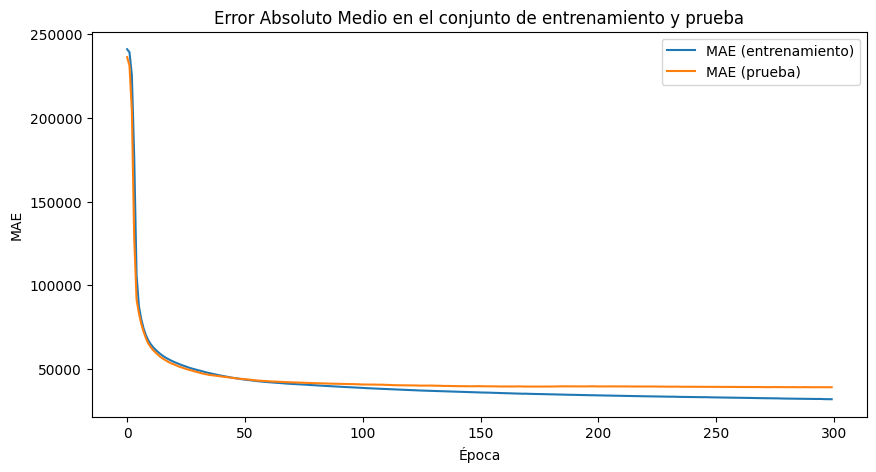

In [65]:
# Obtener la historia del entrenamiento
train_mae_bassline_history = history_bassline.history['mean_absolute_error']
val_mae_bassline_history = history_bassline.history['val_mean_absolute_error']

# Crear un gráfico del error absoluto medio en el conjunto de entrenamiento y prueba
plt.figure(figsize=(10, 5))
plt.plot(train_mae_bassline_history, label='MAE (entrenamiento)')
plt.plot(val_mae_bassline_history, label='MAE (prueba)')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.title('Error Absoluto Medio en el conjunto de entrenamiento y prueba')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


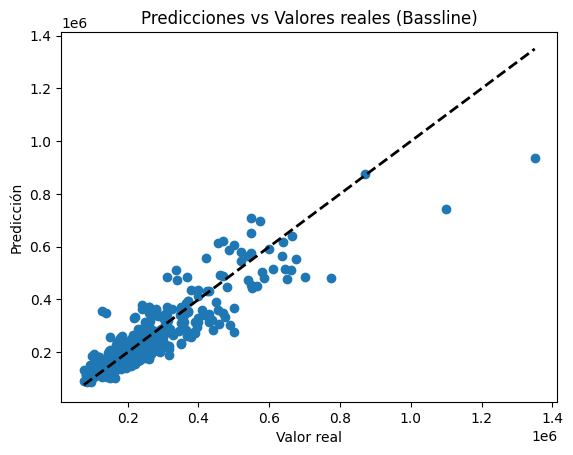

In [221]:
# Graficar las predicciones frente a los valores reales

y_pred_bassline = model_bassline.predict(X_test_encoded_scaled)

plt.scatter(y_test, y_pred_bassline)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Línea diagonal
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicciones vs Valores reales (Bassline)")
plt.show()

In [230]:
# Convertir los DataFrames o matrices bidimensionales a arrays unidimensionales
y_test_array = y_test.values.ravel()
y_pred_array = y_pred_bassline.ravel()

# Calcular las diferencias entre las predicciones y los valores reales
diferencias = abs(y_test_array - y_pred_array)

# Contar el número de predicciones con un error menor a 40000
num_predicciones_menor_40000 = sum(diferencias < 40000)

# Calcular el porcentaje de predicciones con un error menor a 40000
porcentaje_predicciones_menor_40000 = (num_predicciones_menor_40000 / len(y_test_array)) * 100

print("Número de predicciones con error menor a 40000:", num_predicciones_menor_40000)
print("Porcentaje de predicciones con error menor a 40000:", porcentaje_predicciones_menor_40000, "%")

Número de predicciones con error menor a 40000: 334
Porcentaje de predicciones con error menor a 40000: 68.8659793814433 %


In [141]:
dicc_modelo_bassline = crear_resguardo_modelo("red_neuronal_bassline", bassline_model_params['neurons1'],  bassline_model_params['neurons2'], bassline_model_params['neurons3'], bassline_model_params['dropout'], bassline_model_params['activation'],  bassline_model_params['optimizer'],  bassline_model_params['batch_size'],  bassline_model_params['epochs'], bassline_model_params['learning_rate'], train_error_bassline, test_error_bassline, False, True, bassline_model_params['regularization'])

In [142]:
dicc_modelo_bassline

{'Modelo': 'red_neuronal_bassline',
 'Neurons_layer1': 128,
 'Neurons_layer2': 128,
 'Neurons_layer3': 16,
 'Dropout': 0,
 'Regularization': 'None',
 'Optimizer': 'adam',
 'Learning_rate': 0.001,
 'Activation': 'relu',
 'Batch_size': 16,
 'Epochs': 300,
 'Train_error': 31722.591796875,
 'Test_error': 39041.03515625,
 'CV': False,
 'Stratify': True}

In [27]:
# Funcion para crear el modelo de la red neuronal parametrizada (se utilizara para realizar las exploraciones con RandomSearch y GridSearch).

In [118]:
def create_model(units=32, activation='relu', optimizer='adam', dropout=0.1, learning_rate = 0.001, regularization = None):
    model = Sequential()
    model.add(Dense(units=units, activation=activation, kernel_regularizer= regularization, input_shape=(125,)))
    model.add(Dense(units=units, activation=activation, kernel_regularizer= regularization))
    model.add(Dense(units=int(units/8), activation=activation, kernel_regularizer= regularization))
    model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error'])
    return model

In [118]:
# MODELO CON RANDOMSEARCH

In [88]:
# 3 horas aproximadamente de ejecucion
# Definir los hiperparámetros para la búsqueda aleatoria
param_dist = {
    'batch_size':range(8,24,8),
    "model__units":range(64,128,32),
    'model__activation': ['relu'],
    'model__optimizer': ['adam'],
    'model__dropout': np.arange(0, 0.05, 0.01),
    "model__learning_rate": np.arange(0.001,0.03,0.001),
    "model__regularization": [None, regularizers.l2(0.01), regularizers.l1(0.01)]
}

model_random = KerasRegressor(model=create_model, epochs=100, batch_size=16, verbose=0, random_state = 42)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

random_search = RandomizedSearchCV(estimator=model_random, param_distributions=param_dist, cv=kfold, n_iter=72, scoring='neg_mean_absolute_error', verbose=1)
random_search.fit(X_train_encoded_scaled, y_train, callbacks = [early_stopping])


Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\alvar\anaconda3\envs\pruebaPD\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\alvar\anaconda3\envs\pruebaPD\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\alvar\anaconda3\envs\pruebaPD\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=KerasRegressor(batch_size=16, epochs=100, model=<function create_model at 0x000001AB40E55790>, random_state=42, verbose=0),
                   n_iter=72,
                   param_distributions={'batch_size': range(8, 24, 8),
                                        'model__activation': ['relu'],
                                        'model__dropout': array([0.  , 0.01, 0.02, 0.03, 0.04]),
                                        'model__learning_ra...
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029]),
                                        'model__optimizer': ['adam'],
                                        'model__regularization': [None,
                                                                  <keras.src.regularizers.regularizers.L2 object at 0x000001AB56BA9490>,
                                                                  <keras.src.regularizers.regularizers.L1 object at 0x000001AB56BA9850>],
                                        'model__units': range(64, 128, 32)},
                   scoring='neg_mean_absolute_error', verbose=1)

In [89]:
# Recuperar los mejores parametros
random_model_best_params = random_search.best_params_

# Recuperar la mejor score
random_model_best_score = random_search.best_score_

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:", random_model_best_params)
print("Mejor puntuación de validación cruzada:", random_model_best_score)

Mejores hiperparámetros encontrados: {'model__units': 64, 'model__regularization': None, 'model__optimizer': 'adam', 'model__learning_rate': 0.004, 'model__dropout': 0.03, 'model__activation': 'relu', 'batch_size': 16}
Mejor puntuación de validación cruzada: -44165.51298727998


In [90]:
# Obtener los resultados completos
random_model_results = random_search.cv_results_

# Imprimir los resultados completos
for mean_score, params in zip(random_model_results['mean_test_score'], random_model_results['params']):
    print(f"Puntuación media de validación cruzada: {mean_score:.3f} con los siguientes parámetros: {params}")

Puntuación media de validación cruzada: -49191.117 con los siguientes parámetros: {'model__units': 64, 'model__regularization': None, 'model__optimizer': 'adam', 'model__learning_rate': 0.018000000000000002, 'model__dropout': 0.01, 'model__activation': 'relu', 'batch_size': 16}
Puntuación media de validación cruzada: -54876.734 con los siguientes parámetros: {'model__units': 96, 'model__regularization': <keras.src.regularizers.regularizers.L1 object at 0x000001AB56BA9850>, 'model__optimizer': 'adam', 'model__learning_rate': 0.026000000000000002, 'model__dropout': 0.04, 'model__activation': 'relu', 'batch_size': 16}
Puntuación media de validación cruzada: -46292.492 con los siguientes parámetros: {'model__units': 96, 'model__regularization': <keras.src.regularizers.regularizers.L1 object at 0x000001AB56BA9850>, 'model__optimizer': 'adam', 'model__learning_rate': 0.010000000000000002, 'model__dropout': 0.03, 'model__activation': 'relu', 'batch_size': 16}
Puntuación media de validación cr

In [119]:
# Obtener el mejor estimador del RandomizedSearchCV
random_model_best_model = random_search.best_estimator_

# Hacer predicciones en el conjunto de entrenamiento
y_pred_train_random = random_model_best_model.predict(X_train_encoded_scaled)
# Hacer predicciones en el conjunto de prueba
y_pred_random= random_model_best_model.predict(X_test_encoded_scaled)


# Calcular el error en el conjunto de entrenamiento
train_error_random = mean_absolute_error(y_train, y_pred_train_random)
# Calcular el error en el conjunto de prueba
test_error_random = mean_absolute_error(y_test, y_pred_random)

print("Error en el conjunto de entrenamiento:", train_error_random)
print("Error en el conjunto de prueba:", test_error_random)

Error en el conjunto de entrenamiento: 33242.186443136605
Error en el conjunto de prueba: 39663.15865012887


In [120]:
random_model_best_params = {
    key.replace('model__', ''): value for key, value in random_model_best_params.items()
}
random_model_best_params

{'units': 64,
 'regularization': None,
 'optimizer': 'adam',
 'learning_rate': 0.004,
 'dropout': 0.03,
 'activation': 'relu',
 'batch_size': 16}

In [112]:
## Probamos a entrenar el modelo con estos parametros con 300 epochs y vemos como evoluciona el error respecto a los epochs

In [122]:
random_model_best_model = create_model(**{k: random_model_best_params[k] for k in list(random_model_best_params.keys())[:6]})

num_batches_random = random_model_best_params.get('batch_size', None)

# Entrenar el modelo en todo el conjunto de entrenamiento con un número mayor de épocas
history_random_model = random_model_best_model.fit(X_train_encoded_scaled, y_train, epochs=300, batch_size=num_batches_random, validation_data=(X_test_encoded_scaled, y_test), verbose=1)

C:\Users\alvar\anaconda3\envs\pruebaPD\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 241461.4688 - mean_absolute_error: 241461.4688 - val_loss: 235602.1719 - val_mean_absolute_error: 235602.1719
Epoch 2/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 237333.5156 - mean_absolute_error: 237333.5156 - val_loss: 204515.7188 - val_mean_absolute_error: 204515.7188
Epoch 3/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 180889.1094 - mean_absolute_error: 180889.1094 - val_loss: 95050.0312 - val_mean_absolute_error: 95050.0312
Epoch 4/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 91966.8906 - mean_absolute_error: 91966.8906 - val_loss: 80800.8828 - val_mean_absolute_error: 80800.8828
Epoch 5/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 78116.6719 - mean_absolute_error: 78116.6719 - val_loss: 71580.7812 - val_mean_absolute_error: 71580.7812
Epoch 6/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 69970.9297 - mean_absolute_error: 69970.9297 - val_loss: 65294.4609 - val_mean_absolute_error: 65294.4609

In [124]:
# Evaluar el modelo en el conjunto de entrenamiento
train_loss_random, train_error_random = random_model_best_model.evaluate(X_train_encoded_scaled, y_train)

# Evaluar el modelo en el conjunto de prueba
test_loss_random, test_error_random = random_model_best_model.evaluate(X_test_encoded_scaled, y_test)

print("Train Error:", train_error_random)
print("Test Error:", test_error_random)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29279.5996 - mean_absolute_error: 29279.5996
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40321.1562 - mean_absolute_error: 40321.1562 
Train Error: 29333.201171875
Test Error: 39044.75


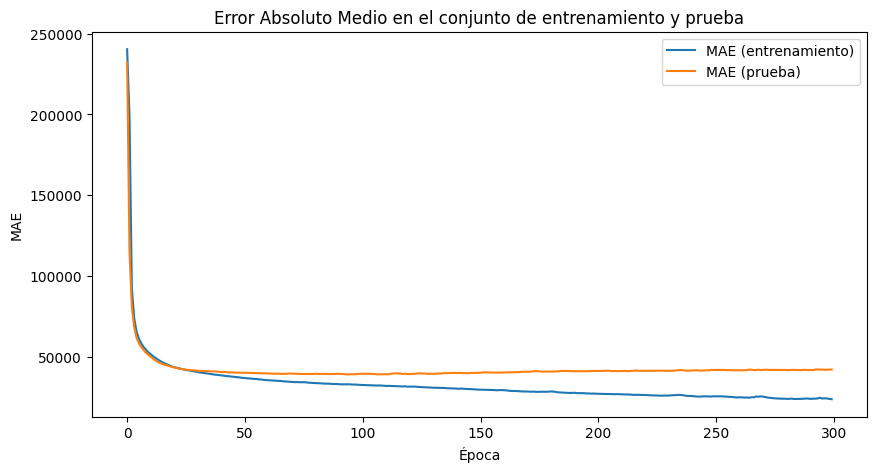

In [116]:
# Obtener la historia del entrenamiento
train_mae_random_model = history_random_model.history['mean_absolute_error']
val_mae_random_model = history_random_model.history['val_mean_absolute_error']

# Crear un gráfico del error absoluto medio en el conjunto de entrenamiento y prueba
plt.figure(figsize=(10, 5))
plt.plot(train_mae_random_model, label='MAE (entrenamiento)')
plt.plot(val_mae_random_model, label='MAE (prueba)')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.title('Error Absoluto Medio en el conjunto de entrenamiento y prueba')
plt.legend()
plt.show()

In [123]:
## Parece que a partir de 100 epochs se sobreajustara ya que el error del test cada vez disminuye menos y el error del train sigue bajando.
## Volvemos a entrenar el modelo con 100 epochs

In [110]:
if (random_model_best_params['regularization'] == None):
    regularization_random = "None"
else:
    regularization_random = random_model_best_params['regularization']

In [125]:
random_model_best_model = create_model(**{k: random_model_best_params[k] for k in list(random_model_best_params.keys())[:6]})

num_batches_random = random_model_best_params.get('batch_size', None)

random_model_params = {
    'neurons1' : random_model_best_params['units'],
    'neurons2' : random_model_best_params['units'],
    'neurons3' : int(random_model_best_params['units']/8),
    'activation' : random_model_best_params['activation'],
    'optimizer' :  random_model_best_params['optimizer'],
    'learning_rate' :  random_model_best_params['learning_rate'],
    'dropout':  random_model_best_params['dropout'],
    'regularization': regularization_random,
    'epochs' : 100,
    'batch_size' :  random_model_best_params['batch_size']
}

# Entrenar el modelo en todo el conjunto de entrenamiento con un número mayor de épocas
history_random_model = random_model_best_model.fit(X_train_encoded_scaled, y_train, epochs=100, batch_size=num_batches_random, validation_data=(X_test_encoded_scaled, y_test), verbose=1)

Epoch 1/100


C:\Users\alvar\anaconda3\envs\pruebaPD\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 241381.0781 - mean_absolute_error: 241381.0781 - val_loss: 233353.6094 - val_mean_absolute_error: 233353.6094
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 228433.5781 - mean_absolute_error: 228433.5781 - val_loss: 140776.1875 - val_mean_absolute_error: 140776.1875
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 114651.6797 - mean_absolute_error: 114651.6797 - val_loss: 83307.2031 - val_mean_absolute_error: 83307.2031
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 79795.9297 - mean_absolute_error: 79795.9297 - val_loss: 70972.0391 - val_mean_absolute_error: 70972.0391
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 69081.5391 - mean_absolute_error: 69081.5391 - val_loss: 63489.5352 - val_mean_absolute_error: 63489.5352
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63746.8945 - mean_absolute_error: 63746.8945 - val_loss: 59646.2227 - val_mean_absolute_error: 59646.2227
Epoch 7/100

In [127]:
# Evaluar el modelo en el conjunto de entrenamiento
train_loss_random, train_error_random = random_model_best_model.evaluate(X_train_encoded_scaled, y_train)

# Evaluar el modelo en el conjunto de prueba
test_loss_random, test_error_random = random_model_best_model.evaluate(X_test_encoded_scaled, y_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34663.4102 - mean_absolute_error: 34663.4102
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39743.3672 - mean_absolute_error: 39743.3672 


In [128]:
print("Train Error:", train_error_random)

Train Error: 33867.59375


In [129]:
print("Test Error:", test_error_random)

Test Error: 39237.57421875


In [131]:
## El error de test es igual que antes (con 300 epochs) pero esta vez hemos sobreajustado menos al conjunto de train por lo que conservamos este modelo.

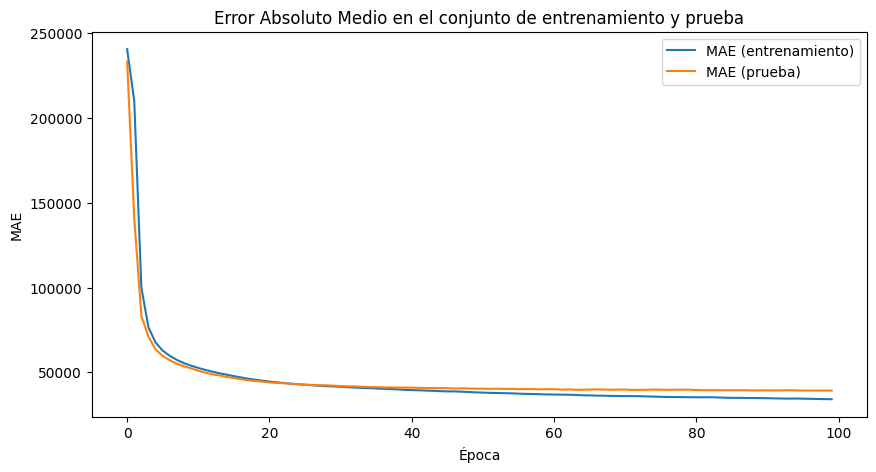

In [130]:
# Obtener la historia del entrenamiento
train_mae_random_model = history_random_model.history['mean_absolute_error']
val_mae_random_model = history_random_model.history['val_mean_absolute_error']

# Crear un gráfico del error absoluto medio en el conjunto de entrenamiento y prueba
plt.figure(figsize=(10, 5))
plt.plot(train_mae_random_model, label='MAE (entrenamiento)')
plt.plot(val_mae_random_model, label='MAE (prueba)')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.title('Error Absoluto Medio en el conjunto de entrenamiento y prueba')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


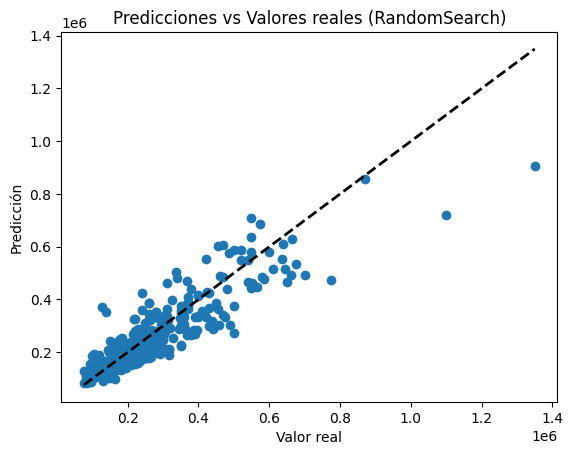

In [223]:
# Graficar las predicciones frente a los valores reales

y_pred_random_model = random_model_best_model.predict(X_test_encoded_scaled)

plt.scatter(y_test, y_pred_random_model)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Línea diagonal
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicciones vs Valores reales (RandomSearch)")
plt.show()

In [231]:
# Convertir los DataFrames o matrices bidimensionales a arrays unidimensionales
y_test_array = y_test.values.ravel()
y_pred_array = y_pred_random_model.ravel()

# Calcular las diferencias entre las predicciones y los valores reales
diferencias = abs(y_test_array - y_pred_array)

# Contar el número de predicciones con un error menor a 40000
num_predicciones_menor_40000 = sum(diferencias < 40000)

# Calcular el porcentaje de predicciones con un error menor a 40000
porcentaje_predicciones_menor_40000 = (num_predicciones_menor_40000 / len(y_test_array)) * 100

print("Número de predicciones con error menor a 40000:", num_predicciones_menor_40000)
print("Porcentaje de predicciones con error menor a 40000:", porcentaje_predicciones_menor_40000, "%")

Número de predicciones con error menor a 40000: 334
Porcentaje de predicciones con error menor a 40000: 68.8659793814433 %


In [137]:
dicc_modelo_random = crear_resguardo_modelo("red_neuronal_randomSearch", random_model_params['neurons1'],  random_model_params['neurons2'],random_model_params['neurons3'], random_model_params['dropout'], random_model_params['activation'],  random_model_params['optimizer'],  random_model_params['batch_size'],  random_model_params['epochs'], random_model_params['learning_rate'], train_error_random, test_error_random, True, True, regularization_random)

In [143]:
dicc_modelo_random

{'Modelo': 'red_neuronal_randomSearch',
 'Neurons_layer1': 64,
 'Neurons_layer2': 64,
 'Neurons_layer3': 8,
 'Dropout': 0.03,
 'Regularization': 'None',
 'Optimizer': 'adam',
 'Learning_rate': 0.004,
 'Activation': 'relu',
 'Batch_size': 16,
 'Epochs': 100,
 'Train_error': 33867.59375,
 'Test_error': 39237.57421875,
 'CV': True,
 'Stratify': True}

In [55]:
guardar_resultados_mlflow(dicc_modelo_random, "Red neuronal randomSearch", random_model_best_model)

In [58]:
# Modelo con grid

In [144]:

# Definir los hiperparámetros para la búsqueda en rejilla
param_grid = {
    'batch_size':[8,16],
    "model__units":[32,64,128],
    'model__activation': ['relu'],
    'model__optimizer': ['adam'],
    'model__dropout': [0, 0.05],
    "model__learning_rate":[0.001, 0.003],
    "model__regularization": [None, regularizers.l2(0.01), regularizers.l1(0.01)]
}



model_grid = KerasRegressor(model=create_model, epochs=100, batch_size=32, verbose=0, random_state = 42)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)




In [145]:
grid_search = GridSearchCV(estimator=model_grid, param_grid=param_grid, cv=kfold, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=2)


In [146]:
grid_search.fit(X_train_encoded_scaled, y_train, callbacks = [early_stopping])

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\alvar\anaconda3\envs\pruebaPD\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KerasRegressor(batch_size=32, epochs=100, model=<function create_model at 0x000001AC365DA040>, random_state=42, verbose=0),
             n_jobs=-1,
             param_grid={'batch_size': [8, 16], 'model__activation': ['relu'],
                         'model__dropout': [0, 0.05],
                         'model__learning_rate': [0.001, 0.003],
                         'model__optimizer': ['adam'],
                         'model__regularization': [None,
                                                   <keras.src.regularizers.regularizers.L2 object at 0x000001AC25C42F40>,
                                                   <keras.src.regularizers.regularizers.L1 object at 0x000001AC25C42A60>],
                         'model__units': [32, 64, 128]},
             scoring='neg_mean_absolute_error', verbose=2)

In [198]:
# Recuperar los mejores parametros
grid_model_best_params = grid_search.best_params_

# Recuperar la mejor score
grid_model_best_score = grid_search.best_score_

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:", grid_model_best_params)
print("Mejor puntuación de validación cruzada:", grid_model_best_score)

Mejores hiperparámetros encontrados: {'batch_size': 16, 'model__activation': 'relu', 'model__dropout': 0, 'model__learning_rate': 0.003, 'model__optimizer': 'adam', 'model__regularization': None, 'model__units': 128}
Mejor puntuación de validación cruzada: -43691.72276153951


In [199]:
# Obtener los resultados completos
grid_model_results = grid_search.cv_results_

# Imprimir los resultados completos
for mean_score, params in zip(grid_model_results['mean_test_score'], grid_model_results['params']):
    print(f"Puntuación media de validación cruzada: {mean_score:.3f} con los siguientes parámetros: {params}")

Puntuación media de validación cruzada: -51340.848 con los siguientes parámetros: {'batch_size': 8, 'model__activation': 'relu', 'model__dropout': 0, 'model__learning_rate': 0.001, 'model__optimizer': 'adam', 'model__regularization': None, 'model__units': 32}
Puntuación media de validación cruzada: -46923.520 con los siguientes parámetros: {'batch_size': 8, 'model__activation': 'relu', 'model__dropout': 0, 'model__learning_rate': 0.001, 'model__optimizer': 'adam', 'model__regularization': None, 'model__units': 64}
Puntuación media de validación cruzada: -45485.308 con los siguientes parámetros: {'batch_size': 8, 'model__activation': 'relu', 'model__dropout': 0, 'model__learning_rate': 0.001, 'model__optimizer': 'adam', 'model__regularization': None, 'model__units': 128}
Puntuación media de validación cruzada: -51566.623 con los siguientes parámetros: {'batch_size': 8, 'model__activation': 'relu', 'model__dropout': 0, 'model__learning_rate': 0.001, 'model__optimizer': 'adam', 'model__re

In [200]:
# Obtener el mejor estimador del GridSearchCV
grid_model_best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de entrenamiento
y_pred_train_grid = grid_model_best_model.predict(X_train_encoded_scaled)
# Hacer predicciones en el conjunto de prueba
y_pred_grid = grid_model_best_model.predict(X_test_encoded_scaled)


# Calcular el error en el conjunto de entrenamiento
train_error_grid = mean_absolute_error(y_train, y_pred_train_grid)
# Calcular el error en el conjunto de prueba
test_error_grid = mean_absolute_error(y_test, y_pred_grid)

print("Error en el conjunto de entrenamiento:", train_error_grid)
print("Error en el conjunto de prueba:", test_error_grid)

Error en el conjunto de entrenamiento: 31995.452351348365
Error en el conjunto de prueba: 38931.02036082474


In [202]:
grid_model_best_params = {
    key.replace('model__', ''): value for key, value in grid_model_best_params.items()
}
grid_model_best_params

{'batch_size': 16,
 'activation': 'relu',
 'dropout': 0,
 'learning_rate': 0.003,
 'optimizer': 'adam',
 'regularization': None,
 'units': 128}

In [ ]:
## Entrenamos el modelo con mejores parametros y 300 epochs para ver si mejora su rendimiento con mas epochs

In [182]:
grid_model_best_model = create_model(**{k: grid_model_best_params[k] for k in list(grid_model_best_params.keys())[1:7]})

num_batches_grid = grid_model_best_params.get('batch_size', None)

# Entrenar el modelo en todo el conjunto de entrenamiento con un número mayor de épocas
history_grid_model = grid_model_best_model.fit(X_train_encoded_scaled, y_train, epochs=300, batch_size=num_batches_grid, validation_data=(X_test_encoded_scaled, y_test), verbose=1)

C:\Users\alvar\anaconda3\envs\pruebaPD\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 241069.7656 - mean_absolute_error: 241069.7656 - val_loss: 224435.0312 - val_mean_absolute_error: 224435.0312
Epoch 2/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 198137.3594 - mean_absolute_error: 198137.3594 - val_loss: 93220.4688 - val_mean_absolute_error: 93220.4688
Epoch 3/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 86793.0312 - mean_absolute_error: 86793.0312 - val_loss: 71658.1953 - val_mean_absolute_error: 71658.1953
Epoch 4/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 69388.3203 - mean_absolute_error: 69388.3203 - val_loss: 61785.2656 - val_mean_absolute_error: 61785.2656
Epoch 5/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62628.9570 - mean_absolute_error: 62628.9570 - val_loss: 57921.5000 - val_mean_absolute_error: 57921.5000
Epoch 6/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 58494.4375 - mean_absolute_error: 58494.4375 - val_loss: 54994.7227 - val_mean_absolute_error: 54994.7227
Epo

In [183]:
# Evaluar el modelo en el conjunto de entrenamiento
train_loss_grid, train_error_grid = grid_model_best_model.evaluate(X_train_encoded_scaled, y_train)

# Evaluar el modelo en el conjunto de prueba
test_loss_grid, test_error_grid = grid_model_best_model.evaluate(X_test_encoded_scaled, y_test)

print("Train Error:", train_error_grid)
print("Test Error:", test_error_grid)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19106.1426 - mean_absolute_error: 19106.1426
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41228.8906 - mean_absolute_error: 41228.8906 
Train Error: 19465.673828125
Test Error: 39990.46484375


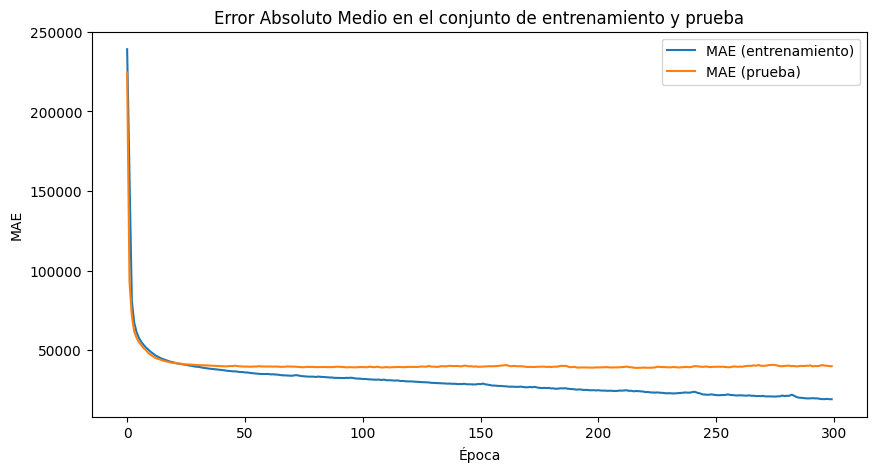

In [184]:
# Obtener la historia del entrenamiento
train_mae_grid_model = history_grid_model.history['mean_absolute_error']
val_mae_grid_model = history_grid_model.history['val_mean_absolute_error']

# Crear un gráfico del error absoluto medio en el conjunto de entrenamiento y prueba
plt.figure(figsize=(10, 5))
plt.plot(train_mae_grid_model, label='MAE (entrenamiento)')
plt.plot(val_mae_grid_model, label='MAE (prueba)')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.title('Error Absoluto Medio en el conjunto de entrenamiento y prueba')
plt.legend()
plt.show()

In [154]:
## Tanto viendo los nuevos errores como el grafico del error vs epochs, vemos que 100 eran suficientes. Más epochs causan sobreajuste y no mejoran el error de test.

In [206]:
grid_model_best_model = create_model(**{k: grid_model_best_params[k] for k in list(grid_model_best_params.keys())[1:7]})

num_batches_grid = grid_model_best_params.get('batch_size', None)

# Entrenar el modelo en todo el conjunto de entrenamiento con un número mayor de épocas
history_grid_model = grid_model_best_model.fit(X_train_encoded_scaled, y_train, epochs=100, batch_size=num_batches_grid, validation_data=(X_test_encoded_scaled, y_test), verbose=1)

C:\Users\alvar\anaconda3\envs\pruebaPD\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 241123.9688 - mean_absolute_error: 241123.9688 - val_loss: 226308.2188 - val_mean_absolute_error: 226308.2188
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 204706.9531 - mean_absolute_error: 204706.9531 - val_loss: 95118.9844 - val_mean_absolute_error: 95118.9844
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 89231.7188 - mean_absolute_error: 89231.7188 - val_loss: 73982.5078 - val_mean_absolute_error: 73982.5078
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 71034.7969 - mean_absolute_error: 71034.7969 - val_loss: 63268.5000 - val_mean_absolute_error: 63268.5000
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 63573.2383 - mean_absolute_error: 63573.2383 - val_loss: 58674.7812 - val_mean_absolute_error: 58674.7812
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 59271.1211 - mean_absolute_error: 59271.1211 - val_loss: 55788.3008 - val_mean_absolute_error: 55788.3008
Epo

In [207]:
if (grid_model_best_params['regularization'] == None):
    regularization_grid = "None"
else:
    regularization_grid = grid_model_best_params['regularization']

grid_model_params = {
    'neurons1' : grid_model_best_params['units'],
    'neurons2' : grid_model_best_params['units'],
    'neurons3' : int(grid_model_best_params['units']/8),
    'activation' : grid_model_best_params['activation'],
    'optimizer' :  grid_model_best_params['optimizer'],
    'learning_rate' :  grid_model_best_params['learning_rate'],
    'dropout':  grid_model_best_params['dropout'],
    'regularization': regularization_grid,
    'epochs' : 100,
    'batch_size' :  grid_model_best_params['batch_size']
}

In [214]:
# Hacer predicciones en el conjunto de entrenamiento
y_pred_train_grid = grid_model_best_model.predict(X_train_encoded_scaled)
# Hacer predicciones en el conjunto de prueba
y_pred_grid_model = grid_model_best_model.predict(X_test_encoded_scaled)


# Calcular el error en el conjunto de entrenamiento
train_error_grid = mean_absolute_error(y_train, y_pred_train_grid)
# Calcular el error en el conjunto de prueba
test_error_grid = mean_absolute_error(y_test, y_pred_grid_model)

print("Error en el conjunto de entrenamiento:", train_error_grid)
print("Error en el conjunto de prueba:", test_error_grid)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Error en el conjunto de entrenamiento: 31977.612255470824
Error en el conjunto de prueba: 38829.8312177835


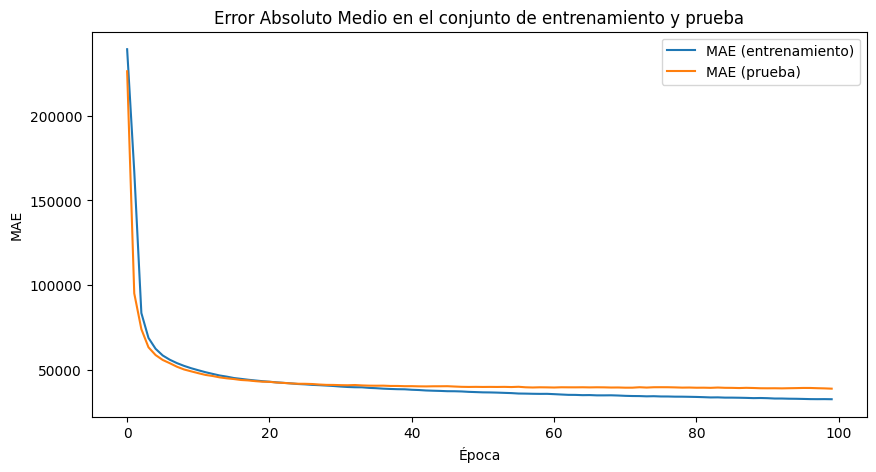

In [215]:
# Obtener la historia del entrenamiento
train_mae_grid_model = history_grid_model.history['mean_absolute_error']
val_mae_grid_model = history_grid_model.history['val_mean_absolute_error']

# Crear un gráfico del error absoluto medio en el conjunto de entrenamiento y prueba
plt.figure(figsize=(10, 5))
plt.plot(train_mae_grid_model, label='MAE (entrenamiento)')
plt.plot(val_mae_grid_model, label='MAE (prueba)')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.title('Error Absoluto Medio en el conjunto de entrenamiento y prueba')
plt.legend()
plt.show()

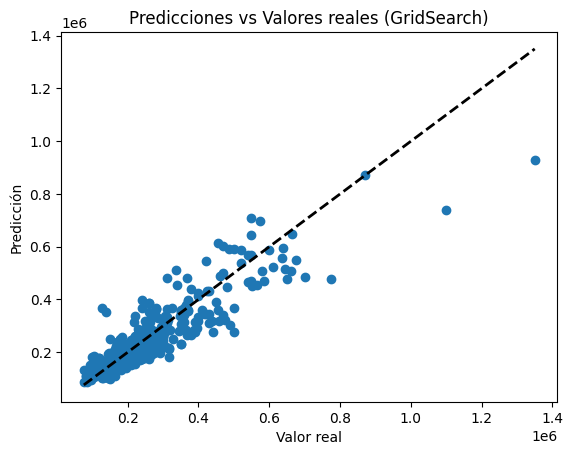

In [236]:
# Graficar las predicciones frente a los valores reales

plt.scatter(y_test, y_pred_grid_model)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Línea diagonal
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicciones vs Valores reales (GridSearch)")
plt.show()

In [233]:
# Convertir los DataFrames o matrices bidimensionales a arrays unidimensionales
y_test_array = y_test.values.ravel()
y_pred_array = y_pred_grid_model.ravel()

# Calcular las diferencias entre las predicciones y los valores reales
diferencias = abs(y_test_array - y_pred_array)

# Contar el número de predicciones con un error menor a 20000
num_predicciones_menor_20000 = sum(diferencias < 40000)

# Calcular el porcentaje de predicciones con un error menor a 20000
porcentaje_predicciones_menor_20000 = (num_predicciones_menor_20000 / len(y_test_array)) * 100

print("Número de predicciones con error menor a 20000:", num_predicciones_menor_20000)
print("Porcentaje de predicciones con error menor a 20000:", porcentaje_predicciones_menor_20000, "%")

Número de predicciones con error menor a 20000: 337
Porcentaje de predicciones con error menor a 20000: 69.48453608247422 %


In [ ]:
## De nuevo vemos que este modelo si que consigue realizar buenas predicciones con la mayoria de casos y de nuevo aun no consigue predecir
## demasiado bien las viviendas demasiado caras, pero no esta tan lejos de lograrlo como el modelo de bassline.

In [218]:
dicc_modelo_grid = crear_resguardo_modelo("red_neuronal_grid", grid_model_params['neurons1'],  grid_model_params['neurons2'], grid_model_params['neurons3'], grid_model_params['dropout'], grid_model_params['activation'],  grid_model_params['optimizer'],  grid_model_params['batch_size'],  grid_model_params['epochs'], grid_model_params['learning_rate'], train_error_grid, test_error_grid, True, True, regularization_grid)

In [219]:
dicc_modelo_grid

{'Modelo': 'red_neuronal_grid',
 'Neurons_layer1': 128,
 'Neurons_layer2': 128,
 'Neurons_layer3': 16,
 'Dropout': 0,
 'Regularization': 'None',
 'Optimizer': 'adam',
 'Learning_rate': 0.003,
 'Activation': 'relu',
 'Batch_size': 16,
 'Epochs': 100,
 'Train_error': 31977.612255470824,
 'Test_error': 38829.8312177835,
 'CV': True,
 'Stratify': True}

In [95]:
## Guardar los experimentos con sqlite

In [1]:
import sqlite3

# Especifica la ruta y el nombre de la base de datos SQLite
database_path = "C:/Universidad/Segundo/dbpd/pd.db"

# Conecta a la base de datos (esto también creará la base de datos si no existe)
conn = sqlite3.connect(database_path)
cursor = conn.cursor()

# Crea una tabla para almacenar los registros de MLflow
cursor.execute('''CREATE TABLE IF NOT EXISTS mlflow (
                    run_id TEXT,
                    experiment_id INTEGER,
                    user_id TEXT,
                    status TEXT,
                    start_time INTEGER,
                    end_time INTEGER,
                    source_name TEXT,
                    source_type INTEGER,
                    source_version TEXT,
                    PRIMARY KEY (run_id)
                )''')

# Guarda los cambios y cierra la conexión
conn.commit()
conn.close()

In [ ]:
import sqlite3

# Conectarse a la base de datos (creará el archivo si no existe)
conexion = sqlite3.connect('C:/Universidad/Segundo/dbpd/pd.db')

# Crear un cursor para ejecutar consultas SQL
cursor = conexion.cursor()

# Ejecutar una consulta para obtener todos los registros de la tabla "runs"
cursor.execute("SELECT * FROM runs")

# Obtener todos los resultados de la consulta
resultados = cursor.fetchall()

# Mostrar los resultados
for resultado in resultados:
    print(resultado)

# Cerrar el cursor y la conexión
cursor.close()
conexion.close()

In [179]:
import mlflow
import mlflow.sklearn

def save_results_mlflow(diccionario_resultados, nombre_modelo, model, experimento):
    ##mlflow.set_tracking_uri(None)
    mlflow.set_tracking_uri("sqlite:///C:/Universidad/Segundo/dbpd/pd.db")
    mlflow.set_experiment(experimento)  # Nombre de tu experimento en MLflow
    with mlflow.start_run() as run:
        metric = 0.0  # Inicializar metric con un valor predeterminado
        for key in diccionario_resultados.keys():
            try:
                if key == 'best_params':
                    for param_key, param_value in diccionario_resultados[key].items():
                        mlflow.log_param(f'best_{param_key}', param_value)
                elif key == 'cross_validation':
                    for dic in diccionario_resultados[key]:
                        log_metric_text = ""
                        for key,value in dic.items():
                            if key != "train_score":
                                log_metric_text+= f" {key}_ {value}"
                            else:
                                metric = value
                        mlflow.log_metric(log_metric_text, metric)
                elif "error" in key:
                    mlflow.log_metric(key, diccionario_resultados[key])
                else:
                    mlflow.log_param(key, diccionario_resultados[key])
            except KeyError as e:
                print(f"Error al procesar la clave {key}: {str(e)}")
                # Puedes agregar aquí otro manejo de errores o simplemente continuar
        mlflow.sklearn.log_model(model, nombre_modelo)

In [180]:
save_results_mlflow(dicc_modelo_bassline, "Red neuronal bassline", model_bassline, "Experimento1")

2024/04/17 00:53:07 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/04/17 00:53:07 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [181]:
save_results_mlflow(dicc_modelo_random, "Red neuronal randomSearch", random_model_best_model, "Experimento2")

2024/04/17 00:53:36 INFO mlflow.tracking.fluent: Experiment with name 'Experimento2' does not exist. Creating a new experiment.


In [182]:
save_results_mlflow(dicc_modelo_grid, "Red neuronal gridSearch", grid_model_best_model, "Experimento3")

2024/04/17 00:53:53 INFO mlflow.tracking.fluent: Experiment with name 'Experimento3' does not exist. Creating a new experiment.
